In [271]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates

In [272]:
import numpy as np
import pandas as pd

In [273]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [274]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [275]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [276]:
# reflect an existing database into a new model
Base = automap_base() 

# reflect the tables
Base.prepare(engine, reflect=True) 

In [277]:
# We can view all of the classes that automap found
Base.classes.keys() 

['measurement', 'station']

In [278]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [279]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [280]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
first_row = session.query(measurement).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x117938410>,
 'station': 'USC00519397',
 'prcp': 0.08,
 'date': '2010-01-01',
 'tobs': 65.0,
 'id': 1}

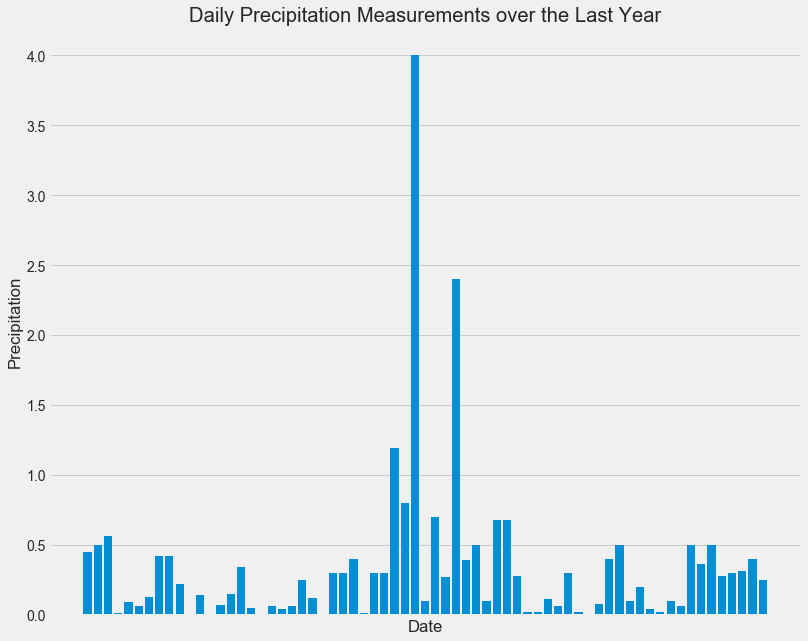

In [299]:
last_year = pd.DataFrame(engine.execute('SELECT date, prcp FROM measurement ORDER BY date DESC LIMIT 365').fetchall())
last_year.columns = ['date', 'prcp']
last_year = last_year.set_index('date')
fig, ax = plt.subplots(figsize=(12, 12))
ax.bar(last_year.index.values, last_year['prcp'])
ax.set(xlabel="Date",
       ylabel="Precipitation",
       title="Daily Precipitation Measurements over the Last Year")
date_form = DateFormatter("%m-%d")
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
plt.gcf().autofmt_xdate()
plt.savefig('daily_precipitation_over_last_year.png')
plt.show()

In [282]:
# Alternate Solution

In [283]:
last_year_date = session.query(measurement.date).order_by(measurement.date.desc()).first()
last_year_date

('2017-08-23')

In [284]:
last_year_alt = pd.DataFrame(session.query(measurement.date, measurement.prcp).\
    filter(measurement.date <= '2017-08-23').\
    filter(measurement.date >= '2016-08-24').all())

In [285]:
last_year_alt.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [286]:
# Design a query to show how many stations are available in this dataset?
session.query(measurement.station).group_by(measurement.station).count()

9

In [287]:
stations = engine.execute('SELECT DISTINCT COUNT(station) FROM measurement GROUP BY station')
pd.Series(stations).count()

9

In [288]:
# What are the most active stations? (i.e. what stations have the most rows)?
active_stations = pd.DataFrame(engine.execute('SELECT DISTINCT station, COUNT(id) FROM measurement GROUP BY station ORDER BY COUNT(id) DESC'))
print(f"The most active station is {active_stations[0][0]}")

# List the stations and the counts in descending order.
active_stations.columns = ['Station', 'Observations']
active_stations = active_stations.set_index('Station')
print(active_stations)

The most active station is USC00519281
             Observations
Station                  
USC00519281          2772
USC00519397          2724
USC00513117          2709
USC00519523          2669
USC00516128          2612
USC00514830          2202
USC00511918          1979
USC00517948          1372
USC00518838           511


In [289]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
temp_df = pd.DataFrame(session.query(measurement.tobs).\
    filter(measurement.station == 'USC00519281').all())
temp_table = pd.DataFrame({'Temperature': ['Lowest', 'Highest', 'Average'], '': [temp_df['tobs'].min(), temp_df['tobs'].max(), temp_df['tobs'].mean()]})
print(temp_table)

  Temperature           
0      Lowest  54.000000
1     Highest  85.000000
2     Average  71.663781


In [290]:
# Alternate Solution
session.query(func.min(measurement.tobs), func.max(measurement.tobs), func.avg(measurement.tobs)).\
    filter(measurement.station == 'USC00519281').all()

[(54.0, 85.0, 71.66378066378067)]

(array([ 5.,  7.,  7., 12., 27., 41., 40., 57., 66., 52., 29.,  8.]),
 array([59., 61., 63., 65., 67., 69., 71., 73., 75., 77., 79., 81., 83.]),
 <a list of 12 Patch objects>)

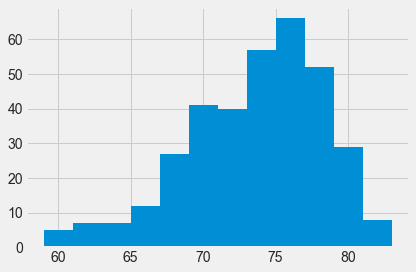

In [300]:
# Choose the station with the highest number of temperature observations. 
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

station_temp = pd.DataFrame(session.query(measurement.date, measurement.tobs).\
    filter(measurement.station == 'USC00519281').\
    filter(measurement.date <= '2017-08-23').\
    filter(measurement.date >= '2016-08-24').all())
x=station_temp['tobs']
fig, ax = plt.subplots(tight_layout=True)
plt.savefig('temp_histogram.png')
ax.hist(x, bins=12)

## Bonus Challenge Assignment

In [296]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)).\
        filter(measurement.date >= start_date).filter(measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [297]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax for your trip using the previous year's data for those same dates.
start_date = dt.datetime(2017, 4, 1)
end_date = dt.datetime(2017, 4, 10)
year_earlier = dt.timedelta(365)
trip = calc_temps(start_date - year_earlier, end_date - year_earlier)
trip = pd.DataFrame(trip[0])
varr = trip[0][2] - trip[0][0]
trip.index = ['Min Temperature', 'Avg Temperature', 'Max Temperature']
trip = trip.transpose()
trip

,Min Temperature,Avg Temperature,Max Temperature
0,65.0,72.844828,78.0


/Users/johnpatten/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  if __name__ == '__main__':


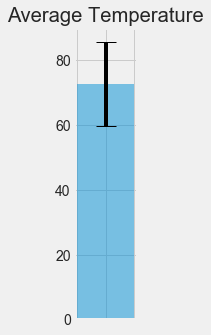

In [303]:
# Plot the results from your previous query as a bar chart. 
y=trip['Avg Temperature']
x=0
fig, ax = plt.subplots(figsize=(1,5))
ax.bar(x, y, yerr=varr, align='center', alpha=0.5, ecolor='black', capsize=10, width=0.1)
ax.set_title('Average Temperature')
ax.xaxis.set_ticklabels([])
ax.yaxis.grid(True)
plt.tight_layout()
plt.savefig('bar_plot_with_error_bars.png')
plt.show()